In [1]:
from keras.layers import  Dropout, Dense
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn import metrics

Using TensorFlow backend.


In [2]:
def TFIDF(X_train, X_test, MAX_NB_WORDS=75000):
    vectorizer_x = TfidfVectorizer(max_features=MAX_NB_WORDS)
    X_train = vectorizer_x.fit_transform(X_train).toarray()
    X_test = vectorizer_x.transform(X_test).toarray()
    print("tf-idf with",str(np.array(X_train).shape[1]),"features")
    return (X_train,X_test)

In [3]:
def Word_vectorizer(X_train, X_test, MAX_NB_WORDS=100000):
    vectorizer = CountVectorizer(max_features=MAX_NB_WORDS)
    X_train = vectorizer.fit_transform(X_train).toarray()
    X_test = vectorizer.transform(X_test).toarray()
    print("words with",str(np.array(X_train).shape[1]),"features")
    return (X_train,X_test)

In [4]:
def Build_Model_DNN_Text(shape, nClasses, dropout=0.5):
    """
    buildModel_DNN_Tex(shape, nClasses,dropout)
    Build Deep neural networks Model for text classification
    Shape is input feature space
    nClasses is number of classes
    """
    model = Sequential()
    node = 512 # number of nodes
    nLayers = 4 # number of  hidden layer

    model.add(Dense(node,input_dim=shape,activation='relu'))
    model.add(Dropout(dropout))
    for i in range(0,nLayers):
        model.add(Dense(node,input_dim=node,activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(nClasses, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [5]:
import pandas as pd
resource = pd.read_csv('adc-word.csv')
from sklearn.model_selection import train_test_split
sentences_train, sentences_test, y_train, y_test = train_test_split(resource['documents'], resource['category'], test_size=0.2, random_state=42)
#from sklearn.datasets import fetch_20newsgroups
#newsgroups_train = fetch_20newsgroups(subset='train')
#newsgroups_test = fetch_20newsgroups(subset='test')
# finally, vectorize the text samples into a 2D integer tensor
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
#y_train = newsgroups_train.target
#y_test = newsgroups_test.target
X_train_tfidf, X_test_tfidf = Word_vectorizer(sentences_train, sentences_test)

words with 100000 features


In [6]:
model_DNN = Build_Model_DNN_Text(X_train_tfidf.shape[1], 8)
model_DNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               51200512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

In [7]:
model_DNN.fit(X_train_tfidf, y_train, validation_data=(X_test_tfidf, y_test), epochs=5, batch_size=128, verbose=2)

Train on 54191 samples, validate on 13548 samples
Epoch 1/5
 - 618s - loss: 0.7990 - accuracy: 0.7331 - val_loss: 0.5032 - val_accuracy: 0.8245
Epoch 2/5
 - 697s - loss: 0.3931 - accuracy: 0.8694 - val_loss: 0.4760 - val_accuracy: 0.8471
Epoch 3/5
 - 680s - loss: 0.2410 - accuracy: 0.9195 - val_loss: 0.5945 - val_accuracy: 0.8445
Epoch 4/5
 - 475s - loss: 0.1732 - accuracy: 0.9454 - val_loss: 0.7166 - val_accuracy: 0.8469
Epoch 5/5
 - 475s - loss: 0.1454 - accuracy: 0.9547 - val_loss: 0.7810 - val_accuracy: 0.8452


In [8]:
predicted = model_DNN.predict_classes(X_test_tfidf)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      4926
           1       0.82      0.87      0.85      3215
           2       0.86      0.86      0.86      3147
           3       0.99      0.98      0.99       766
           4       0.97      0.98      0.98       631
           5       0.67      0.26      0.37       435
           6       0.84      0.78      0.81       313
           7       0.90      0.94      0.92       115

    accuracy                           0.85     13548
   macro avg       0.86      0.81      0.82     13548
weighted avg       0.84      0.85      0.84     13548



In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted)

In [12]:
from sklearn.metrics import accuracy_score
print("Accuracy : ", accuracy_score(y_test, predicted))

Accuracy :  0.8452170062001771


In [10]:
print(cm)

[[4099  472  257    7   10   55   21    5]
 [ 243 2808  150    0    4    0    4    6]
 [ 282  137 2710    0    2    0   16    0]
 [  14    1    0  751    0    0    0    0]
 [   9    3    0    0  618    0    1    0]
 [ 310    2    3    0    1  112    6    1]
 [  34    4   30    0    0    0  245    0]
 [   1    4    2    0    0    0    0  108]]


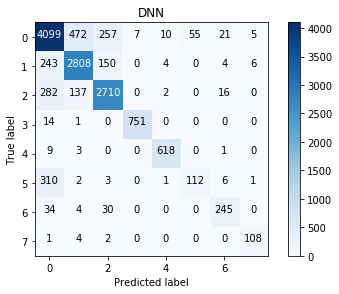

In [11]:
import matplotlib.pyplot as plt
import itertools
cmap = plt.cm.Blues
title = "DNN"
classes = 8
normalize = False
tick_marks = np.arange(classes)
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(10)
#plt.xticks(tick_marks, classes, rotation=45)
#plt.yticks(tick_marks, classes)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 5.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()